<a href="https://colab.research.google.com/github/jeaneigsi/cookbook/blob/main/Idefics2_inference_optimization_tradeoffs_between_memory_and_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab provides the code to run the memory/speed benchmarks to optimize Idefics2's inference.

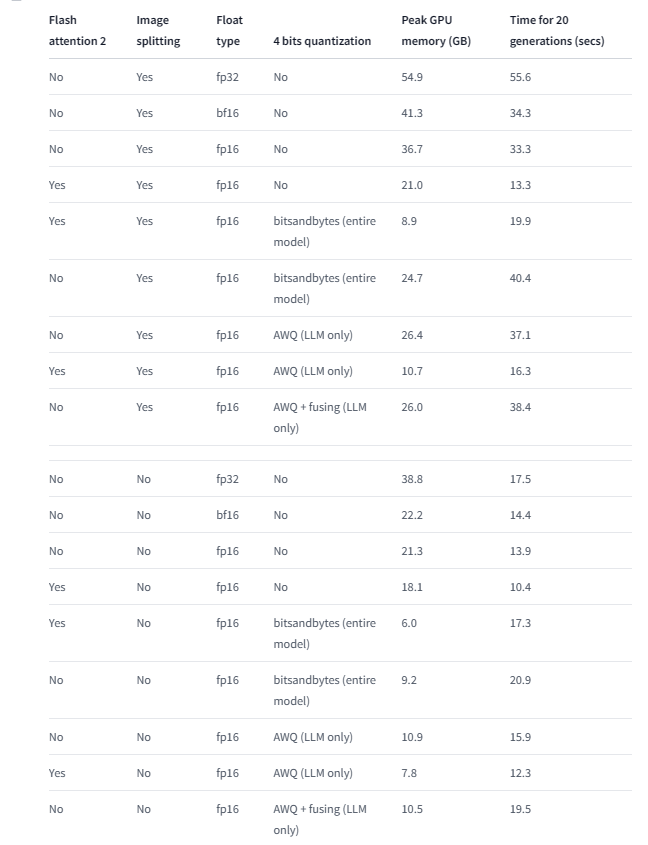

In [1]:
!pip install -q  bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 19.9 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/casper-hansen/AutoAWQ.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-hf1byjn5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hf1byjn5
  Resolved https://github.com/huggingface/transformers.git to commit 8c12690cecbb97e187861e386f7a0ac790e4236c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 5.2 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9012708 sha256=e872447ad675265f3793cba28cceacd743174e28877f863514974e1bcc92501b
  Stored in directory: /tmp/pip-ephem-wheel-cache-oz7rmh6s/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      S

In [3]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 35.3 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.7-cp310-cp310-linux_x86_64.whl size=120853563 sha256=bbe6f77fd0899f8a125a5bdcf734b660c4c88e81c9b51c7ce98ebeba44dc6fa0
  Stored in directory: /root/.cache/pip/wheels/13/96/ed/bcac89c56b606421f99b45b16a94db5d0f2b6b4eaf8bac4d01
Successfully built flash-attn


In [4]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq, AwqConfig, BitsAndBytesConfig
from transformers.image_utils import load_image
import time

DEVICE = "cuda:0"

In [5]:
# These are the only variables to change
IMAGE_SPLITTING = False
DTYPE = torch.float16 # [torch.float32, torch.float16, torch.bfloat16]
ATTN_IMPLEMENTATION = None # [None, "flash_attention_2"]
QUANTIZATION_SCHEME = "awq" # [None, "bitsandbytes", "awq"]
AWQ_FUSING = False

In [6]:
model_name = "HuggingFaceM4/idefics2-8b"

if QUANTIZATION_SCHEME is not None:
    if QUANTIZATION_SCHEME == "bitsandbytes":
        quantization_config = BitsAndBytesConfig(
          load_in_4bit=True,
          bnb_4bit_quant_type="nf4",
          bnb_4bit_use_double_quant=True,
          bnb_4bit_compute_dtype=torch.float16
        )
    elif QUANTIZATION_SCHEME == "awq":
        if AWQ_FUSING:
            if ATTN_IMPLEMENTATION is not None:
                raise ValueError("Cannot use flash attention with AWQ Quantization")
            quantization_config = AwqConfig(
                bits=4,
                fuse_max_seq_len=4096,
                modules_to_fuse={
                    "attention": ["q_proj", "k_proj", "v_proj", "o_proj"],
                    "mlp": ["gate_proj", "up_proj", "down_proj"],
                    "layernorm": ["input_layernorm", "post_attention_layernorm", "norm"],
                    "use_alibi": False,
                    "num_attention_heads": 32,
                    "num_key_value_heads": 8,
                    "hidden_size": 4096,
                }
            )
        model_name = "HuggingFaceM4/idefics2-8b-AWQ"
    else:
        raise ValueError("Unknown configuration")


processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=IMAGE_SPLITTING
)
if QUANTIZATION_SCHEME == "bitsandbytes":
    model = AutoModelForVision2Seq.from_pretrained(
        model_name,
        torch_dtype=DTYPE,
        _attn_implementation=ATTN_IMPLEMENTATION,
        quantization_config=quantization_config,
    )
elif QUANTIZATION_SCHEME == "awq" and AWQ_FUSING:
    model = AutoModelForVision2Seq.from_pretrained(
        model_name,
        torch_dtype=DTYPE,
        _attn_implementation=ATTN_IMPLEMENTATION,
        quantization_config=quantization_config,
    ).to(DEVICE)
else:
    model = AutoModelForVision2Seq.from_pretrained(
        model_name,
        torch_dtype=DTYPE,
        _attn_implementation=ATTN_IMPLEMENTATION,
    ).to(DEVICE)


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/959 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [7]:
# Note that passing the image urls (instead of the actual pil images) to the processor is also possible
# image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
# image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
# image3 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")

image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
image3 = load_image("https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg")


"""
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

"""

'\nmessages = [\n    {\n        "role": "user",\n        "content": [\n            {"type": "image"},\n            {"type": "text", "text": "What do we see in this image?"},\n        ]\n    },\n    {\n        "role": "assistant",\n        "content": [\n            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},\n        ]\n    },\n    {\n        "role": "user",\n        "content": [\n            {"type": "image"},\n            {"type": "text", "text": "And how about this image?"},\n        ]\n    },\n]\nprompt = processor.apply_chat_template(messages, add_generation_prompt=True)\ninputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")\ninputs = {k: v.to(DEVICE) for k, v in inputs.items()}\n\n'

In [8]:
# Create inputs
prompts = [
  "<image>In this image, we can see the city of New York, and more specifically the Statue of Liberty.<image>In this image,",
  "In which city is that bridge located?<image>",
]
images = [[image1, image2], [image3]]
inputs = processor(text=prompts, images=images, padding=True, return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}


# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


['In this image, we can see the city of New York, and more specifically the Statue of Liberty. In this image, we can see buildings, trees, lights and water. In the background, we can see the sky.', 'In which city is that bridge located? San Francisco is a city located on the west coast of the United States. It is known for its iconic Golden Gate Bridge. The Golden Gate Bridge is a suspension bridge that spans the Golden Gate Strait, which connects the San Francisco Bay to the Pacific Ocean. The bridge is a popular tourist attraction and a symbol of San Francisco.\n\n\nAnswer: San Francisco.']


In [9]:
NB_REPEATS = 20
start = time.time()
for i in range(NB_REPEATS):
    generated_ids = model.generate(**inputs, max_new_tokens=500)

print("time for 20 generations:", (time.time() - start))
print("max memory allocated:", torch.cuda.max_memory_allocated())
print("number of tokens generated:", len(generated_ids[:, inputs["input_ids"].size(1):][0]))
print(processor.batch_decode(generated_ids, skip_special_tokens=True))

time for 20 generations: 171.5233302116394
max memory allocated: 12856867840
number of tokens generated: 79
['In this image, we can see the city of New York, and more specifically the Statue of Liberty. In this image, we can see buildings, trees, lights and water. In the background, we can see the sky.', 'In which city is that bridge located? San Francisco is a city located on the west coast of the United States. It is known for its iconic Golden Gate Bridge. The Golden Gate Bridge is a suspension bridge that spans the Golden Gate Strait, which connects the San Francisco Bay to the Pacific Ocean. The bridge is a popular tourist attraction and a symbol of San Francisco.\n\n\nAnswer: San Francisco.']
